In [1]:
import os
import torch
import torchvision
import numpy as np
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


In [2]:
from scipy.io import loadmat
from PIL import Image
from glob import glob

# Load label and split data
labels = loadmat('imagelabels.mat')['labels'][0]
split = loadmat('setid.mat')
train_ids = split['trnid'][0] - 1  # convert to 0-based indexing
val_ids = split['valid'][0] - 1
test_ids = split['tstid'][0] - 1

image_paths = sorted(glob('102flowers/jpg/*.jpg'))  # assuming extracted images are here
print(f"Total images: {len(image_paths)}") 
import os
print(os.listdir("102flowers"))


Total images: 8189
['imagelabels.mat', 'jpg', 'setid.mat']


In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Simple transform for visualization
preview_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


In [4]:
from torch.utils.data import Dataset

class FlowersDataset(Dataset):
    def __init__(self, image_paths, labels, indices, transform=None):
        self.image_paths = [image_paths[i] for i in indices]
        self.labels = [labels[i] - 1 for i in indices]  # 0-based labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


In [5]:
preview_dataset = FlowersDataset(image_paths, labels, train_ids, transform=preview_transform)
preview_loader = DataLoader(preview_dataset, batch_size=8, shuffle=True)

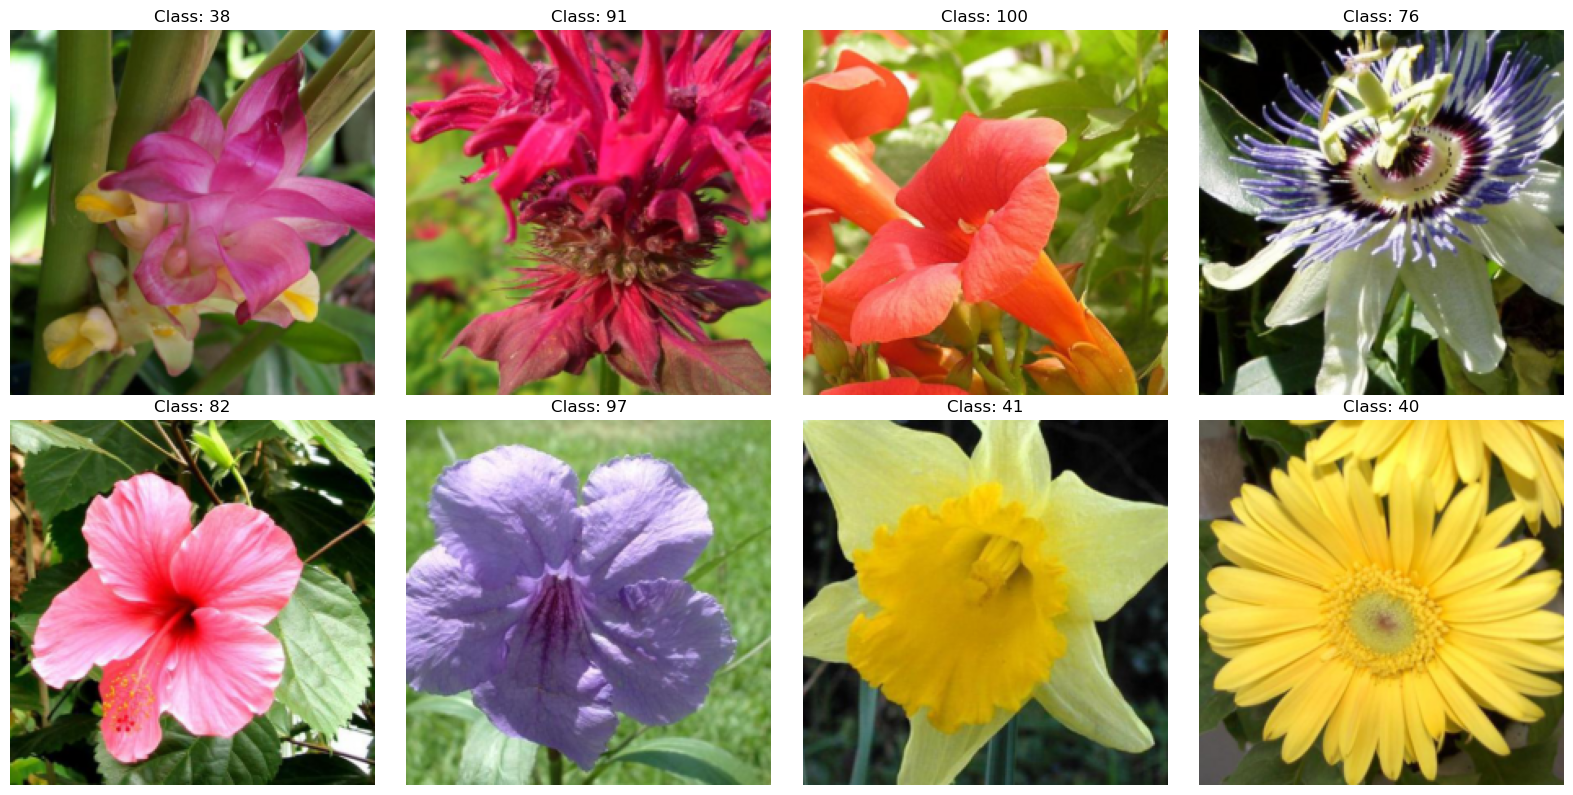

In [6]:
# Helper to unnormalize tensor to image
def imshow(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # CHW → HWC
    plt.imshow(img)
    plt.axis('off')

#get a batch
images, labels_batch = next(iter(preview_loader))

#plot the batch
plt.figure(figsize=(16, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    imshow(images[i])
    plt.title(f"Class: {labels_batch[i].item()}")
plt.tight_layout()
plt.show()


In [7]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = FlowersDataset(image_paths, labels, train_ids, transform=train_transform)
val_dataset = FlowersDataset(image_paths, labels, val_ids, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [8]:
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step()
        print()

    print("Training complete.")
    return model


In [11]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
--------------------
Train Loss: 4.3612 Acc: 0.1392
Val   Loss: 3.7388 Acc: 0.6098

Epoch 2/10
--------------------
Train Loss: 3.2132 Acc: 0.8059
Val   Loss: 2.9763 Acc: 0.7706

Epoch 3/10
--------------------
Train Loss: 2.3882 Acc: 0.9245
Val   Loss: 2.4233 Acc: 0.8127

Epoch 4/10
--------------------
Train Loss: 1.8178 Acc: 0.9569
Val   Loss: 2.0286 Acc: 0.8314

Epoch 5/10
--------------------
Train Loss: 1.3781 Acc: 0.9725
Val   Loss: 1.6941 Acc: 0.8490

Epoch 6/10
--------------------
Train Loss: 1.1589 Acc: 0.9941
Val   Loss: 1.6936 Acc: 0.8451

Epoch 7/10
--------------------
Train Loss: 1.1103 Acc: 0.9863
Val   Loss: 1.6955 Acc: 0.8539

Epoch 8/10
--------------------
Train Loss: 1.0628 Acc: 0.9882
Val   Loss: 1.6606 Acc: 0.8559

Epoch 9/10
--------------------
Train Loss: 1.0483 Acc: 0.9912
Val   Loss: 1.6411 Acc: 0.8510

Epoch 10/10
--------------------
Train Loss: 1.0517 Acc: 0.9902
Val   Loss: 1.6626 Acc: 0.8549

Training complete.


In [12]:
test_dataset = FlowersDataset(image_paths, labels, test_ids, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

In [13]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    test_loss = 0.0
    corrects = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
    
    test_loss = test_loss / len(data_loader.dataset)
    test_acc = corrects.double() / len(data_loader.dataset)
    
    print(f"Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.4f}")


In [14]:
evaluate_model(trained_model, test_loader, criterion)

Test Loss: 1.7047  Test Accuracy: 0.8266


In [15]:
torch.save(trained_model.state_dict(), "resnet50_flowers.pth")
print("Model saved to resnet50_flowers.pth")

Model saved to resnet50_flowers.pth


In [16]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model.load_state_dict(torch.load("resnet50_flowers.pth"))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
def visualize_predictions(model, data_loader, class_names=None, num_images=8):
    model.eval()

    if class_names is None:
        class_names = [str(i) for i in range(102)]  #default to numeric class labels

    images_shown = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                img = inputs[i].cpu()
                label = labels[i].item()
                pred = preds[i].item()

                # Unnormalize
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = img.clamp(0, 1)

                plt.imshow(img.permute(1, 2, 0))
                plt.title(f"True: {class_names[label]} | Pred: {class_names[pred]}")
                plt.axis('off')
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return


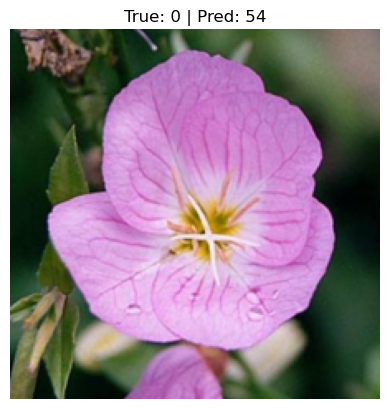

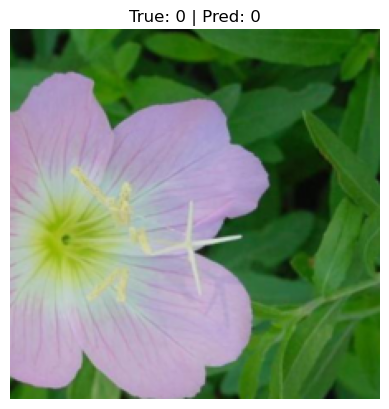

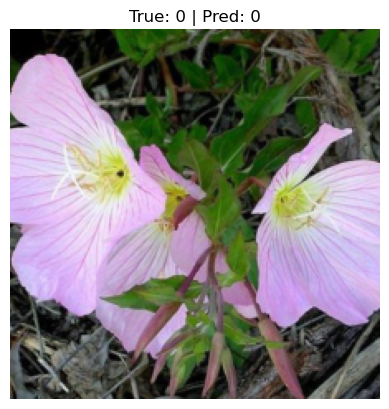

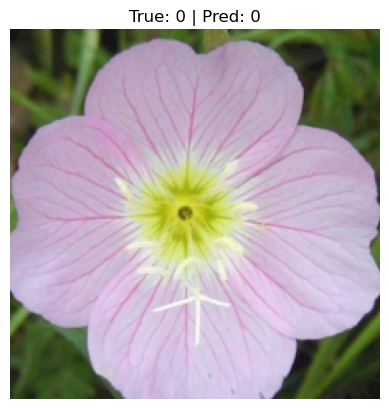

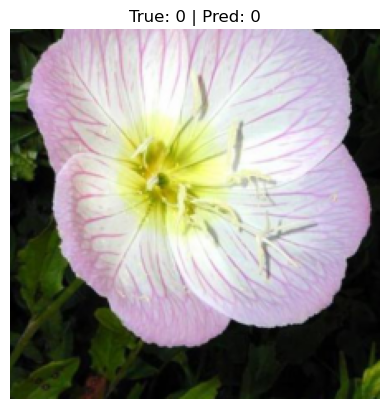

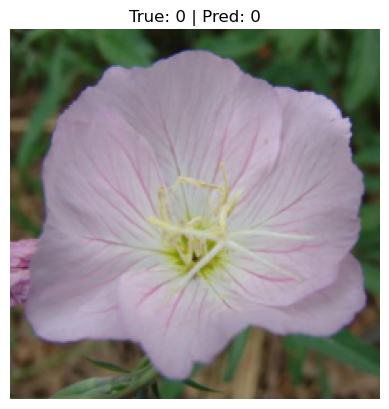

In [18]:
visualize_predictions(trained_model, test_loader, num_images=6)

In [19]:
#unfreeze last two layers (layer3 and layer4)
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [20]:
params_to_update = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_update, lr=1e-4)  #lower LR for fine-tuning


In [21]:
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [22]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5
--------------------
Train Loss: 0.3322 Acc: 0.9755
Val   Loss: 0.5589 Acc: 0.8863

Epoch 2/5
--------------------
Train Loss: 0.0759 Acc: 0.9961
Val   Loss: 0.4617 Acc: 0.8961

Epoch 3/5
--------------------
Train Loss: 0.0348 Acc: 1.0000
Val   Loss: 0.4200 Acc: 0.9029

Epoch 4/5
--------------------
Train Loss: 0.0198 Acc: 1.0000
Val   Loss: 0.3830 Acc: 0.9118

Epoch 5/5
--------------------
Train Loss: 0.0150 Acc: 0.9990
Val   Loss: 0.3700 Acc: 0.9147

Training complete.


In [23]:
print("Before Fine-Tuning:")
evaluate_model(model, test_loader, criterion)

#fine-tuning

print("After Fine-Tuning:")
evaluate_model(trained_model, test_loader, criterion)


Before Fine-Tuning:
Test Loss: 0.4474  Test Accuracy: 0.8818
After Fine-Tuning:
Test Loss: 0.4474  Test Accuracy: 0.8818


In [24]:
def visualize_predictions(model, dataset, class_names, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for i in range(len(dataset)):
            image, label = dataset[i]
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            plt.subplot(2, 4, images_shown + 1)
            imshow(image.cpu())
            plt.title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[label]}")
            plt.axis("off")

            images_shown += 1
            if images_shown == num_images:
                break
    plt.tight_layout()
    plt.show()


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='.2g')
    plt.title("Confusion Matrix")
    plt.show()


In [27]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [28]:
torch.save(model, "full_model.pt")

In [29]:
model = torch.load("full_model.pt", weights_only=False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def imshow(img_tensor, title=None):
    img = img_tensor.clone().detach()
    img = TF.to_pil_image(img)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_predictions(model, dataset, class_names, device, num_images=6):
    model.eval()
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        img, label = dataset[i]
        input_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

        plt.subplot(2, 3, i+1)
        imshow(img, title=f"Pred: {class_names[pred.item()]}\nTrue: {class_names[label]}")
    
    plt.tight_layout()
    plt.show()

In [31]:
class_names = [f"Class {i+1}" for i in range(102)]


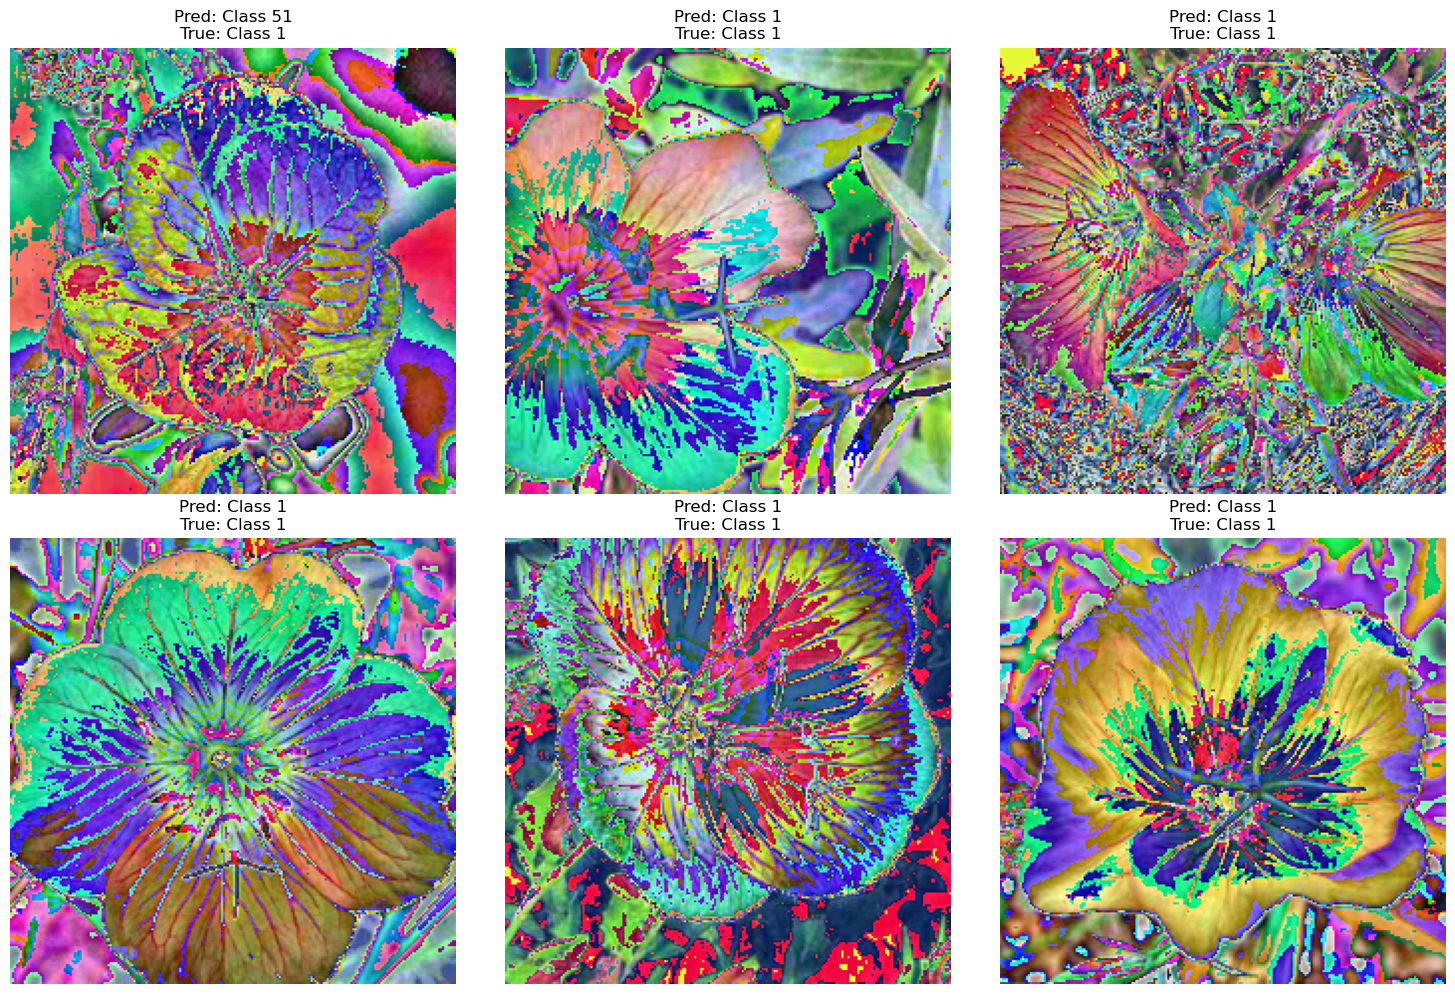

In [32]:
visualize_predictions(model, test_dataset, class_names, device)


In [33]:
pip install gradio


Note: you may need to restart the kernel to use updated packages.


In [34]:
import gradio as gr
from PIL import Image

def predict(image):
    model.eval()
    image = val_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probs = torch.nn.functional.softmax(outputs[0], dim=0)
    top5_probs, top5_idxs = probs.topk(5)
    return {class_names[idx.item()]: float(prob) for idx, prob in zip(top5_idxs, top5_probs)}

interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=5),
    title="Flower Classifier 🌸",
    description="Upload a flower image to classify it into one of 102 flower categories."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
